# Make Posterior Bananas!

In [2]:

# basic imports
from __future__ import print_function
import numpy as np
from numpy.linalg import eig, inv
import time

# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
cmap = cm.RdBu_r



# exptool imports
from exptool.io import psp_io
from exptool.utils import kde_3d
from exptool.observables import transform
from exptool.analysis import pattern
from exptool.analysis import trapping
from exptool.utils import *
from exptool.observables import visualize
from exptool.basis import spheresl
from exptool.basis import eof

# astropy imports
import astropy.coordinates as coord
import astropy.units as u

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline
import scipy

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2





In [3]:

def norm_histogram(arr,bins=-1):
    
    if bins == -1:
        bins = int(len(arr)/100.)
        
    a = np.percentile(arr,0.0)
    A = np.percentile(arr,99.9)
    binvals = np.linspace(a,A,bins)
    outvals = np.zeros(binvals.size)
    #print(a,A,bins)
    da = (A-a)/(bins)
    
    for val in arr:
        #print(val-a,(val-a)/(da))
        indx = (val-a)/da
        if indx>bins-1: indx=bins-1
        #print(indx)
        outvals[int(indx)] += 1
        
    return binvals,outvals/(len(arr)*(A-a)/(bins-1))



66.27494819437237
65.83696638959239


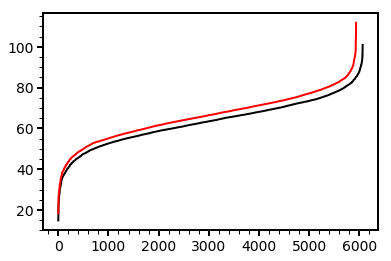

In [4]:
pfile = '/Users/mpetersen/Dropbox/mike/data/satellites_filtered.posteriors'
pfile = '/Users/mpetersen/Dropbox/mike/data/KGiants_d050150_sgr20_L3000_corr.posteriors'
A = np.genfromtxt(pfile)
phi = (180./np.pi)*A[:,1]
plt.plot(phi[phi.argsort()],color='black')

pfile = '/Users/mpetersen/Dropbox/mike/analysis/KGiants_d050150_sgr20_L3000.posteriors'
pfile = '/Users/mpetersen/Dropbox/mike/analysis/KGiants_d050150_sgr20_L3000.posterior'
A = np.genfromtxt(pfile)
phi = (180./np.pi)*A[:,1]
plt.plot(phi[phi.argsort()],color='red')



print(np.nanpercentile(phi,50.))
print(np.nanmean(phi))

In [47]:
def read_posterior(pfile,shift=True):
    
    A = np.genfromtxt(pfile)
    
    dname = {}
    dname['vtravel'] = A[:,0]
    dname['phi'] = (180./np.pi)*A[:,1]
    if shift:
        dname['phi'][dname['phi']<0.] += 360.
    else:
        dname['phi'] += 180.
    dname['theta'] = 90.-(180./np.pi)*np.arccos(A[:,2])
    dname['sigmar'] = 1./np.sqrt(A[:,3])
    dname['sigmap'] = 1./np.sqrt(A[:,4])
    dname['sigmat'] = 1./np.sqrt(A[:,5])
    dname['vra'] = A[:,6]
    dname['vth'] = A[:,7]
    dname['vphi'] = A[:,8]
    
    return dname


ALL = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/all_d050150_sgr20_L3000.posterior')
BHB = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/BHBs_d050150_sgr20_L3000.posterior')
KGiants = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/KGiants_d050150_sgr20_L3000.posterior')
SAT = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/sats.posterior')
#RRL = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/RRL_d050150.posterior')


GC = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/GCs_d008.posterior')
#GC = read_posterior('/Users/mpetersen/Dropbox/mike/analysis/GCs_d025.posterior')

# with no RRL
ALL = read_posterior('/Users/mpetersen/Dropbox/mike/data/all_d050150_sgr20_L3000.posteriors')

# Hobson+ 00 weighted
#ALL = read_posterior('/Users/mpetersen/Dropbox/mike/data/all_average_d050150_sgr20_L3000.posterior')

# set BHBs and K Giants with new posteriors
#BHB = read_posterior('/Users/mpetersen/Dropbox/mike/data/dcorr/BHBs_d050150_sgr20_L3000_d09.posteriors')
#KGiants = read_posterior('/Users/mpetersen/Dropbox/mike/data/dcorr/KGiants_d050150_sgr20_L3000_d09.posteriors')

# the new filtered satellite posteriors
SAT = read_posterior('/Users/mpetersen/Dropbox/mike/data/satellites_filtered.posteriors')

KGiants = read_posterior('/Users/mpetersen/Dropbox/mike/data/KGiants_d050150_sgr20_L3000_corr.posteriors')
SAT = read_posterior('/Users/mpetersen/Dropbox/mike/data/satellites_mcconnachie_minimum.posteriors')
BHB = read_posterior(      '/Users/mpetersen/Dropbox/mike/data/BHBs_d050150_sgr20_L3000_corr.posteriors')
#BHB = read_posterior(      '/Users/mpetersen/Dropbox/mike/data/BHBs_d050150_sgr20_L3000_lanc_corr.posteriors')

KGiants = read_posterior('/Users/mpetersen/Dropbox/mike/data/KGiants_d040150_sgr20_L3000_corr.posteriors')
#SAT = read_posterior('/Users/mpetersen/Dropbox/mike/data/satellites_original_minimum.posteriors')
BHB = read_posterior(      '/Users/mpetersen/Dropbox/mike/data/BHBs_d040150_sgr20_L3000_lanc_corr.posteriors')



cats = ['vtravel','phi','theta','sigmar','sigmap','sigmat','vra','vth','vphi']
dictnames = [ALL,BHB,KGiants,SAT,GC]

def total_bounds(dictnames,cats):
    
    bounddict = {}
    
    for cat in cats:
        bounddict[cat] = [np.percentile(np.array(np.concatenate([dictname[cat] for dictname in dictnames])),0.2),\
                          np.percentile(np.array(np.concatenate([dictname[cat] for dictname in dictnames])),99.8)]

    return bounddict

bounddict = total_bounds(dictnames,cats)

    

In [53]:
!ls /Users/mpetersen/Dropbox/mike/data/*_cov.posteriors

indir = '/Users/mpetersen/Dropbox/mike/data/'

N1 = read_posterior(indir+'fit_nearby_vel_sgr_cov.posteriors',shift=False)
N1s = read_posterior(indir+'fit_nearby_sdss_vel_sgr_cov.posteriors',shift=False)
N2 = read_posterior(indir+'fit_sphere333_vel_sgr_cov.posteriors',shift=False)
N2s = read_posterior(indir+'fit_sphere333_sdss_vel_sgr_cov.posteriors',shift=False)




/Users/mpetersen/Dropbox/mike/data/fit_nearby_sdss_vel_sgr_cov.posteriors
/Users/mpetersen/Dropbox/mike/data/fit_nearby_vel_sgr_cov.posteriors
/Users/mpetersen/Dropbox/mike/data/fit_sphere333_sdss_vel_sgr_cov.posteriors
/Users/mpetersen/Dropbox/mike/data/fit_sphere333_vel_sgr_cov.posteriors


In [8]:
!ls /Users/mpetersen/Dropbox/mike/Models_15May/*.posteriors



/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s13_35k_d050150.posteriors
/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s13rev_35k_d050150.posteriors
/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s14_35k_d050150.posteriors
/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s14rev_35k_d050150.posteriors
/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s15_35k_d050150.posteriors
/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_s15rev_35k_d050150.posteriors


In [24]:
!ls /Users/mpetersen/Dropbox/mike/analysis/*.posteriors

indir = '/Users/mpetersen/Dropbox/mike/analysis/'
indir = '/Users/mpetersen/Dropbox/mike/analysis/'

S13 = read_posterior(indir+'mock_live_s13_d050150.posteriors',shift=False)
S14 = read_posterior(indir+'mock_live_s14_d050150.posteriors',shift=False)
S15 = read_posterior(indir+'mock_live_s15_d050150.posteriors',shift=False)

indir = '/Users/mpetersen/Dropbox/mike/Models_15May/'

S13 = read_posterior(indir+'mock_live_s13_35k_d050150.posteriors',shift=False)
S14 = read_posterior(indir+'mock_live_s14_35k_d050150.posteriors',shift=False)
S15 = read_posterior(indir+'mock_live_s15_35k_d050150.posteriors',shift=False)




/Users/mpetersen/Dropbox/mike/analysis/mock_live_s13_d050150.posteriors
/Users/mpetersen/Dropbox/mike/analysis/mock_live_s14_d050150.posteriors
/Users/mpetersen/Dropbox/mike/analysis/mock_live_s15_d050150.posteriors


In [327]:
!ls /Users/mpetersen/Dropbox/mike/data/*.posteriors

indir = '/Users/mpetersen/Dropbox/mike/data/'
BHB40 = read_posterior(indir+'BHBs_d040150_sgr20_L3000.posteriors')
KGiants40 = read_posterior(indir+'KGiants_d040150_sgr20_L3000.posteriors')




/Users/mpetersen/Dropbox/mike/data/BHBs_d040150_sgr20_L3000.posteriors
/Users/mpetersen/Dropbox/mike/data/KGiants_d040150_sgr20_L3000.posteriors
/Users/mpetersen/Dropbox/mike/data/KGiants_d050150_sgr20_L3000_poor.posteriors
/Users/mpetersen/Dropbox/mike/data/KGiants_d050150_sgr20_L3000_rich.posteriors
/Users/mpetersen/Dropbox/mike/data/all_d050150_sgr20_L3000.posteriors
/Users/mpetersen/Dropbox/mike/data/all_d050150_sgr20_L3000_poor.posteriors
/Users/mpetersen/Dropbox/mike/data/all_d050150_sgr20_L3000_rich.posteriors


In [52]:
!ls /Users/mpetersen/Dropbox/mike/data/*.posterior

indir = '/Users/mpetersen/Dropbox/mike/data/'
A2030 = read_posterior(indir+'all_d020030_sgr20_L3000.posterior')
A3040 = read_posterior(indir+'all_d030040_sgr20_L3000.posterior')
A4050 = read_posterior(indir+'all_d040050_sgr20_L3000.posterior')
A5060 = read_posterior(indir+'all_d050150_sgr20_L3000.posteriors')



/Users/mpetersen/Dropbox/mike/data/BHBs_d050100_rlb_rotation_z.posterior
/Users/mpetersen/Dropbox/mike/data/KGiants_d050100_rlb_rotation_z.posterior
/Users/mpetersen/Dropbox/mike/data/RRL_cohen_rotation_z.posterior
/Users/mpetersen/Dropbox/mike/data/all_RRL_d050150_sgr20_L3000.posterior
/Users/mpetersen/Dropbox/mike/data/all_average_d050150_sgr20_L3000.posterior
/Users/mpetersen/Dropbox/mike/data/all_d020030_sgr20_L3000.posterior
/Users/mpetersen/Dropbox/mike/data/all_d025035_sgr20_L3000.posterior
/Users/mpetersen/Dropbox/mike/data/all_d030040_sgr20_L3000.posterior
/Users/mpetersen/Dropbox/mike/data/all_d035045_sgr20_L3000.posterior
/Users/mpetersen/Dropbox/mike/data/all_d040050_sgr20_L3000.posterior
/Users/mpetersen/Dropbox/mike/data/all_d050100_rlb_rotation_z.posterior
/Users/mpetersen/Dropbox/mike/data/sats_rotation_z.posterior


In [324]:
print(np.nanmedian(S15['phi']))

179.6209264708471


In [303]:
!ls /Users/mpetersen/Dropbox/mike/data/*.posteriors

indir = '/Users/mpetersen/Dropbox/mike/data/'
KGiantsRich = read_posterior(indir+'KGiants_d050150_sgr20_L3000_rich.posteriors')
KGiantsPoor = read_posterior(indir+'KGiants_d050150_sgr20_L3000_poor.posteriors')

AllRich = read_posterior(indir+'all_d050150_sgr20_L3000_rich.posteriors')
AllPoor = read_posterior(indir+'all_d050150_sgr20_L3000_poor.posteriors')


/Users/mpetersen/Dropbox/mike/data/KGiants_d050150_sgr20_L3000_poor.posteriors
/Users/mpetersen/Dropbox/mike/data/KGiants_d050150_sgr20_L3000_rich.posteriors
/Users/mpetersen/Dropbox/mike/data/all_d050150_sgr20_L3000.posteriors
/Users/mpetersen/Dropbox/mike/data/all_d050150_sgr20_L3000_poor.posteriors
/Users/mpetersen/Dropbox/mike/data/all_d050150_sgr20_L3000_rich.posteriors


In [262]:
!ls /Users/mpetersen/Dropbox/mike/data/dcorr/

BHBs_d050150_sgr20_L3000_d09.posteriors
BHBs_d050150_sgr20_L3000_d11.posteriors
KGiants_d050150_sgr20_L3000_d09.posteriors
KGiants_d050150_sgr20_L3000_d11.posteriors
all_d050150_sgr20_L3000_d09.posteriors
all_d050150_sgr20_L3000_d11.posteriors


In [269]:
BHB9 = read_posterior('/Users/mpetersen/Dropbox/mike/data/dcorr/BHBs_d050150_sgr20_L3000_d09.posteriors')
KGiants9 = read_posterior('/Users/mpetersen/Dropbox/mike/data/dcorr/KGiants_d050150_sgr20_L3000_d09.posteriors')
BHB11 = read_posterior('/Users/mpetersen/Dropbox/mike/data/dcorr/BHBs_d050150_sgr20_L3000_d11.posteriors')
KGiants11 = read_posterior('/Users/mpetersen/Dropbox/mike/data/dcorr/KGiants_d050150_sgr20_L3000_d11.posteriors')
ALL11 = read_posterior('/Users/mpetersen/Dropbox/mike/data/dcorr/all_d050150_sgr20_L3000_d11.posteriors')
ALL9 = read_posterior('/Users/mpetersen/Dropbox/mike/data/dcorr/all_d050150_sgr20_L3000_d09.posteriors')





In [297]:
!ls /Users/mpetersen/Dropbox/mike/data/v0_220/


BHBs_d050150_sgr20_L3000_220.posteriors
BHBs_d050150_sgr20_L3000_240.posteriors
KGiants_d050150_sgr20_L3000_220.posteriors
KGiants_d050150_sgr20_L3000_240.posteriors
all_d050150_sgr20_L3000_220.posteriors
all_d050150_sgr20_L3000_240.posteriors
comp_dist_all_v0220.png
comp_dist_bhb_v0220.png
comp_dist_kgiant_v0220.png
ls: /Users/mpetersen/Dropbox/mike/data/v0_240/: No such file or directory


In [298]:
BHB220 = read_posterior('/Users/mpetersen/Dropbox/mike/data/v0_220/BHBs_d050150_sgr20_L3000_220.posteriors')
KGiants220 = read_posterior('/Users/mpetersen/Dropbox/mike/data/v0_220/KGiants_d050150_sgr20_L3000_220.posteriors')
ALL220 = read_posterior('/Users/mpetersen/Dropbox/mike/data/v0_220/all_d050150_sgr20_L3000_220.posteriors')

BHB240 = read_posterior('/Users/mpetersen/Dropbox/mike/data/v0_220/BHBs_d050150_sgr20_L3000_240.posteriors')
KGiants240 = read_posterior('/Users/mpetersen/Dropbox/mike/data/v0_220/KGiants_d050150_sgr20_L3000_240.posteriors')
ALL240 = read_posterior('/Users/mpetersen/Dropbox/mike/data/v0_220/all_d050150_sgr20_L3000_240.posteriors')



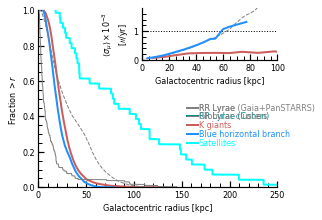

In [105]:
# interpolate the distance function to select mock stars
   
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
    
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8

mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False




fig = plt.figure(figsize=(4.0,3))
ax = fig.add_axes([0.12,0.13,0.83,0.82])


I = np.genfromtxt('../Shells/satdist.txt')

radj = I[:,0]; num = I[:,1]


spl = UnivariateSpline(num,radj,k=4,s=1)
spl = interp1d(num,radj,'nearest')
tstdist = np.linspace(0.,1.,1000)
plt.plot(spl(tstdist),1.-tstdist,color='cyan')




I = np.genfromtxt('../Shells/kgiantrange.txt')

#print(I)
radj = I[:,0]; num = I[:,1]
# invert to interpolate

spl = interp1d(num,radj,'nearest')
tstdist = np.linspace(0.,1.,1000)
plt.plot(spl(tstdist),1.-tstdist,color='indianred')



I = np.genfromtxt('../Shells/bhbgiantrange.txt')


#print(I)
radj = I[:,0]; num = I[:,1]
# invert to interpolate
spl = UnivariateSpline(num,radj,k=4,s=1)
spl = interp1d(num,radj,'nearest')
tstdist = np.linspace(0.,1.,1000)
ax.plot(spl(tstdist),1.-tstdist,color='dodgerblue')


I = np.genfromtxt('../Shells/gcrange.txt')

#print(I)
radj = I[:,0]; num = I[:,1]
# invert to interpolate
spl = UnivariateSpline(num,radj,k=4,s=1)
spl = interp1d(num,radj,'nearest')
tstdist = np.linspace(0.,1.,1000)
ax.plot(spl(tstdist),1.-tstdist,color='gray',lw=1.)


I = np.genfromtxt('../Shells/rrldist.txt')

#print(I)
radj = I[:,0]; num = I[:,1]
# invert to interpolate
spl = UnivariateSpline(num,radj,k=4,s=1)
spl = interp1d(num,radj,'nearest')
tstdist = np.linspace(0.,1.,1000)
ax.plot(spl(tstdist),1.-tstdist,color='gray',linestyle='dashed',lw=1.)



#plt.text(40.,0.5,'K Giants',color='black',size=10)
#plt.text(40.,0.4,'BHBs',color='red',size=10)
#plt.text(40.,0.3,'GCs',color='blue',size=10)

miny = 0.25
for idict,dictname in enumerate(dictnames):
    ax.text(73.+95.,miny+idict*.05,compname[idict],color=colorlist[idict],size=8,va='center')
    ax.plot([60.+95.,72.+95.],[miny+idict*.05,miny+idict*.05],color=colorlist[idict])
   

ax.text(73.+95.,miny+3*.05,'Globular clusters',color='gray',size=8,va='center')
ax.plot([60.+95.,72.+95.],[miny+3*.05,miny+3*.05],color='gray',lw=1.)

ax.text(73.+95.,miny+4*.05,'RR Lyrae',color='gray',size=8,va='center')
ax.plot([60.+95.,72.+95.],[miny+4*.05,miny+4*.05],color='gray',linestyle='dashed',lw=1.)



ax.tick_params(axis="both",which='both',direction="in")
#ax.tick_params(axis="x",which='bottom',direction="in",pad=5)

ax.set_xticks(np.arange(0.,251,50.))

ax.set_xlabel('Galactocentric radius [kpc]',size=8)
ax.set_ylabel('Fraction $>r$',size=8)

ax.axis([0.,250.,0.,1.])

# add a subpanel w/errors.

ax2 = fig.add_axes([0.48,0.72,0.47,0.24])

ax2.plot([0.,100.],[1.,1.],color='black',linestyle='dotted',lw=1.)



I = np.genfromtxt('rrlsignnoise.txt')
dist = I[:,0]; sn = I[:,1]
ax2.plot(dist,sn,color='gray',linestyle='dashed',lw=1.)

I = np.genfromtxt('kgiantsignnoise.txt')
dist = I[:,0]; sn = I[:,1]
ax2.plot(dist,sn,color='indianred',lw=2.)

I = np.genfromtxt('bhbsignnoise.txt')
dist = I[:,0]; sn = I[:,1]
ax2.plot(dist,sn,color='dodgerblue',lw=2.)

ax2.axis([0.,100.,0.,1.8])

ax2.tick_params(axis="both",which='both',direction="in")

ax2.set_xlabel('Galactocentric radius [kpc]',size=8)
ax2.set_ylabel('$\\langle \\sigma_\mu \\rangle\\times10^{-3}$\n[$\prime\prime$/yr]',size=8)


#plt.savefig('/Users/mpetersen/Dropbox/mike/data/distance_distribution.png')
plt.savefig('figures/distance_distribution.png')






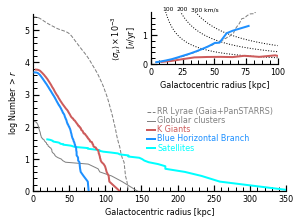

In [76]:


# interpolate the distance function to select mock stars
   
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
    
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8

mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False




fig = plt.figure(figsize=(4.0,3))
ax = fig.add_axes([0.08,0.13,0.88,0.82])


I = np.genfromtxt('rrldistdist.txt')
I = np.genfromtxt('rrldistdist_kpc.txt')


radj = I[:,0]; num = I[:,1]
ax.plot(radj,np.log10(num),color='gray',linestyle='dashed',lw=1.)


# GCs
In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/GCs_cartesian_heliocentric.txt',skip_header=1)
d = In[:,8]
dsort = d.argsort()
nrange = np.arange(0.,d.size,1)
radj = d[dsort]
num = d.size - nrange

ax.plot(radj,np.log10(num),color='gray',lw=1.)


In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr.txt',skip_header=1)
d = In[:,8]
dsort = d.argsort()
nrange = np.arange(0.,d.size,1)
radj = d[dsort]
num = d.size - nrange

ax.plot(radj,np.log10(num),color='indianred',lw=2.,zorder=101)

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr.txt',skip_header=1)
d = In[:,8]
dsort = d.argsort()
nrange = np.arange(0.,d.size,1)
radj = d[dsort]
num = d.size - nrange

ax.plot(radj,np.log10(num),color='dodgerblue',lw=2.,zorder=100)

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/satellites_filtered_cartesian_heliocentric.txt',skip_header=1)
d = In[:,8]
dsort = d.argsort()
nrange = np.arange(0.,d.size,1)
radj = d[dsort]
num = d.size - nrange

ax.plot(radj,np.log10(num),color='cyan',lw=2.)

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/RRL_cohen_cartesian_heliocentric_sgr.txt',skip_header=1)
d = In[:,8]
dsort = d.argsort()
nrange = np.arange(0.,d.size,1)
radj = d[dsort]
num = d.size - nrange


miny = 1.35
dy = 0.28

compname=['Satellites','Blue horizontal branch','K giants','RR Lyrae (Cohen)','RR Lyrae (Gaia+PanSTARRS)','Globular clusters']
colorlist = ['cyan','dodgerblue','indianred','darkcyan','gray','gray']

compname=['Satellites','Blue Horizontal Branch','K Giants','Globular clusters','RR Lyrae (Gaia+PanSTARRS)']
colorlist = ['cyan','dodgerblue','indianred','gray','gray']


push = 2.
for idict in [0,1,2,3,4]:
    ax.text(170.+push,miny+idict*dy,compname[idict],color=colorlist[idict],size=8,va='center')
    if idict>2:
        if idict==4:
            ax.plot([155.+push,167.+push],[miny+idict*dy,miny+idict*dy],color=colorlist[idict],lw=1.,linestyle='dashed')
        else:
            ax.plot([155.+push,167.+push],[miny+idict*dy,miny+idict*dy],color=colorlist[idict],lw=1.)
    else:
        ax.plot([155.+push,167.+push],[miny+idict*dy,miny+idict*dy],color=colorlist[idict])
   


ax.tick_params(axis="both",which='both',direction="in")
#ax.tick_params(axis="x",which='bottom',direction="in",pad=5)

ax.set_xticks(np.arange(0.,351,50.))

ax.set_xlabel('Galactocentric radius [kpc]',size=8)
ax.set_ylabel('log Number $>r$',size=8)

ax.axis([0.,350.,0.,5.5])

# add a subpanel w/errors.

ax2 = fig.add_axes([0.49,0.72,0.44,0.24])

#ax2.plot([0.,100.],[1.,1.],color='black',linestyle='dotted',lw=1.)

k = 4.74057
D = np.linspace(0.,100.,1000)

v = 100.
mu = v/(k*D)
ax2.plot(D,mu,color='black',linestyle='dotted',lw=1.)

v = 300.
mu = v/(k*D)
ax2.plot(D,mu,color='black',linestyle='dotted',lw=1.)

v = 200.
mu = v/(k*D)
ax2.plot(D,mu,color='black',linestyle='dotted',lw=1.)

ax2.text(18.,1.8,'100',color='black',size=6,ha='right',va='bottom')
ax2.text(25.,1.8,'200',color='black',size=6,ha='center',va='bottom')
ax2.text(32.,1.8,'300 km/s',color='black',size=6,ha='left',va='bottom')




I = np.genfromtxt('rrlsignnoise.txt')
dist = I[:,0]; sn = I[:,1]
ax2.plot(dist,sn,color='gray',linestyle='dashed',lw=1.)

I = np.genfromtxt('kgiantsignnoise.txt')
dist = I[:,0]; sn = I[:,1]
ax2.plot(dist,sn,color='indianred',lw=2.)

I = np.genfromtxt('bhbsignnoise.txt')
dist = I[:,0]; sn = I[:,1]
ax2.plot(dist,sn,color='dodgerblue',lw=2.)

ax2.axis([0.,100.,0.,1.8])
ax2.set_xticks(np.arange(0.,101.,25))


ax2.tick_params(axis="both",which='both',direction="in")

ax2.set_xlabel('Galactocentric radius [kpc]',size=8)
ax2.set_ylabel('$\\langle \\sigma_\mu \\rangle\\times10^{-3}$\n[$\prime\prime$/yr]',size=8)


plt.savefig('/Users/mpetersen/Dropbox/mike/data/number_distribution_updated.png')
plt.savefig('/Users/mpetersen/Downloads/number_distribution_updated.png')







In [9]:
# look for substructure in BHBs

mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top']   = True

def return_angular_momentum(In):
    
    x    = In[:,0]
    y    = In[:,1]
    z    = In[:,2]
    vx   = In[:,3]
    vy   = In[:,4]
    vz   = In[:,5]
    
    Lx = (y*vz - z*vy)
    Ly = (z*vx - x*vz)
    Lz = (x*vy - y*vx)

    return Lx,Ly,Lz



def clean_sgr(Lx,Ly,Lz,sgrcen):
    lxdiff = Lx - sgrcen[0]
    lydiff = Ly - sgrcen[1]
    lzdiff = Lz - sgrcen[2]
    ldiff = np.sqrt(lxdiff*lxdiff + lydiff*lydiff + lzdiff*lzdiff)
    return ldiff

sgrvals = [605, -4515, -1267]
ldiff = clean_sgr(Lx,Ly,Lz,sgrvals)





fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr.txt',skip_header=1)
Lx,Ly,Lz = return_angular_momentum(In)
d = In[:,8]

ax1.scatter(Lx,Ly,color='black',s=1.)
ax2.scatter(Lx,Lz,color='black',s=1.)
ax3.scatter(Lz,Ly,color='black',s=1.)

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr.txt',skip_header=1)
ax1.scatter(Lx,Ly,color='black',s=1.)
ax2.scatter(Lx,Lz,color='black',s=1.)
ax3.scatter(Lz,Ly,color='black',s=1.)


In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr.txt',skip_header=1)
Lx,Ly,Lz = return_angular_momentum(In)
d = In[:,8]

dlim = 50
ax1.scatter(Lx[d>dlim],Ly[d>dlim],color='indianred',s=10.)
ax2.scatter(Lx[d>dlim],Lz[d>dlim],color='indianred',s=10.)
ax3.scatter(Lz[d>dlim],Ly[d>dlim],color='indianred',s=10.)



In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr.txt',skip_header=1)

Lx,Ly,Lz = return_angular_momentum(In)
d = In[:,8]


dlim = 50
ax1.scatter(Lx[d>dlim],Ly[d>dlim],color='dodgerblue',s=10.)
ax2.scatter(Lx[d>dlim],Lz[d>dlim],color='dodgerblue',s=10.)
ax3.scatter(Lz[d>dlim],Ly[d>dlim],color='dodgerblue',s=10.)


circlerad = 3000
circlevals = np.linspace(0.,2*np.pi,100)
sgrvals = [605, -4515, -1267]
ax1.plot(circlerad*np.cos(circlevals)+sgrvals[0],circlerad*np.sin(circlevals)+sgrvals[1],color='gold',lw=1.)
ax2.plot(circlerad*np.cos(circlevals)+sgrvals[0],circlerad*np.sin(circlevals)+sgrvals[2],color='gold',lw=1.)
ax3.plot(circlerad*np.cos(circlevals)+sgrvals[2],circlerad*np.sin(circlevals)+sgrvals[1],color='gold',lw=1.)

circlerad = 5000
circlevals = np.linspace(0.,2*np.pi,100)
sgrvals = [-605, 4515, 1267]
ax1.plot(circlerad*np.cos(circlevals)+sgrvals[0],circlerad*np.sin(circlevals)+sgrvals[1],color='gold',lw=1.)
ax2.plot(circlerad*np.cos(circlevals)+sgrvals[0],circlerad*np.sin(circlevals)+sgrvals[2],color='gold',lw=1.)
ax3.plot(circlerad*np.cos(circlevals)+sgrvals[2],circlerad*np.sin(circlevals)+sgrvals[1],color='gold',lw=1.)





for iax,ax in enumerate([ax1,ax2,ax3]):
    maxval = 15000
    ax.axis([-maxval,maxval,-maxval,maxval])

    
plt.savefig('/Users/mpetersen/Dropbox/mike/data/sgr_test_50+kpc.png')



# 605, -4515, 1267

NameError: name 'Lx' is not defined

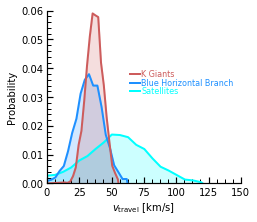

In [48]:

mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

mpl.rcParams['xtick.major.size'] = 6.
mpl.rcParams['xtick.minor.size'] = 4.
mpl.rcParams['ytick.major.size'] = 6.
mpl.rcParams['ytick.minor.size'] = 4.

dictnames = [SAT,BHB,KGiants]#,ALL]
compname = ['Satellites','Blue Horizontal Branch','K Giants']#,'Combined stars']
colorlist = ['cyan','dodgerblue','indianred']#,'silver']



nbins = 20
fig = plt.figure(figsize=(3.5,3))
ax = fig.add_axes([0.18,0.15,0.77,0.8])

for idict,dictname in enumerate(dictnames):
        A,B = norm_histogram(dictname['vtravel'],bins=nbins)

        ax.fill_between(A,np.zeros(A.size),B,color=colorlist[idict],alpha=0.2)

for idict,dictname in enumerate(dictnames):
        Aa,Bb = norm_histogram(dictname['vtravel'],bins=nbins)
        A = np.concatenate([[0.],Aa,[1.01*np.nanmax(Aa)]])
        B = np.concatenate([[0.],Bb,[0.]])

        ax.plot(A,B,color=colorlist[idict])#,linestyle='steps-mid')
        ax.text(73.,0.032+idict*0.003,compname[idict],color=colorlist[idict],size=8,va='center')
        ax.plot([64.,72.],[0.032+idict*0.003,0.032+idict*0.003],color=colorlist[idict])
        
ax.axis([0.,150.,0.,0.06])


ax.tick_params(axis="both",which='both',direction="in")

ax.set_xticks(np.arange(0.,151,25.))

ax.set_xlabel('$v_{\\rm travel}$ [km/s]',size=10)
ax.set_ylabel('Probability',size=10)

plt.savefig('figures/vtravel_correlated_mcconnachie_40.png',dpi=300)

In [44]:

def report_posteriors(posteriors):
    
    usecats = ['vtravel','phi','theta','vra','vphi','vth','sigmar','sigmap','sigmat']

    decoded = ['$v_{\\rm travel}$ [km/s]','$\ell$ [deg]','$b$ [deg]',\
           '$\\langle v_r\\rangle$ [km/s]','$\\langle v_{\\phi}\\rangle $ [km/s]','$\\langle v_{\\theta}\\rangle$ [km/s]',\
          '$\\sigma_{h,{\\rm los}}$ [km/s]','$\\sigma_{h,\ell}$ [km/s]','$\\sigma_{h,b}$ [km/s]']


    
    for ikey,key in enumerate(usecats):
        print('{0} & '.format(decoded[ikey]),end='')
        for posterior in posteriors:
        
            lodiff = np.percentile(posterior[key],50.)-np.percentile(posterior[key],50.-33.3)
            midriff = np.percentile(posterior[key],50.)
            hidiff = np.percentile(posterior[key],50.+33.3)-np.percentile(posterior[key],50.)
            print('${0:2.0f}^{{+{1:2.0f}}}_{{-{2:2.0f}}}$ '.format(midriff,hidiff,lodiff),end='')
            if posterior != SAT:
                print('&',end='')
        print('\\\\')
        
report_posteriors([ALL,KGiants,BHB,SAT])

$v_{\rm travel}$ [km/s] & $48^{+ 8}_{- 8}$ &$37^{+ 6}_{- 6}$ &$33^{+ 9}_{-10}$ &$54^{+25}_{-26}$ \\
$\ell$ [deg] & $70^{+10}_{-10}$ &$78^{+10}_{-10}$ &$63^{+21}_{-22}$ &$103^{+53}_{-41}$ \\
$b$ [deg] & $-22^{+ 9}_{-10}$ &$-24^{+10}_{-11}$ &$-40^{+18}_{-16}$ &$-47^{+22}_{-18}$ \\
$\langle v_r\rangle$ [km/s] & $-3^{+ 6}_{- 6}$ &$-12^{+ 5}_{- 5}$ &$-22^{+ 8}_{- 8}$ &$-22^{+17}_{-17}$ \\
$\langle v_{\phi}\rangle $ [km/s] & $-17^{+12}_{-12}$ &$-24^{+ 7}_{- 8}$ &$-1^{+11}_{-11}$ &$-29^{+23}_{-23}$ \\
$\langle v_{\theta}\rangle$ [km/s] & $ 2^{+ 8}_{- 7}$ &$13^{+ 7}_{- 6}$ &$ 3^{+12}_{-12}$ &$-52^{+32}_{-32}$ \\
$\sigma_{h,{\rm los}}$ [km/s] & $89^{+ 3}_{- 3}$ &$94^{+ 3}_{- 3}$ &$94^{+ 4}_{- 4}$ &$98^{+13}_{-11}$ \\
$\sigma_{h,\ell}$ [km/s] & $194^{+12}_{-11}$ &$137^{+ 7}_{- 6}$ &$103^{+ 9}_{- 8}$ &$110^{+21}_{-17}$ \\
$\sigma_{h,b}$ [km/s] & $68^{+ 6}_{- 6}$ &$99^{+ 4}_{- 4}$ &$129^{+ 9}_{- 8}$ &$136^{+22}_{-17}$ \\


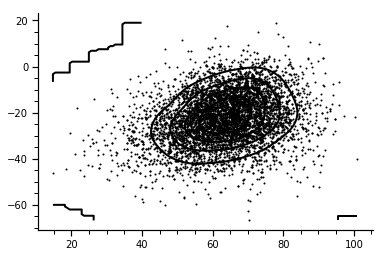

In [22]:
#

def make_banana(array1,array2,bounds=[-1,-1,-1,-1],gridsize=128):
    
    a,A = np.nanmin(array1),np.nanmax(array1)
    b,B = np.nanmin(array2),np.nanmax(array2)
    da,db = (A-a)/128.,(B-b)/128.
    
    if bounds[0]==bounds[1]:
        bounds = [a,A,b,B]
    
    
    xx,yy,dens = kde_3d.total_kde_two(array1,array2,\
                                       gridsize=gridsize,\
                                       extents=bounds,\
                                       ktype='gaussian',npower=8.)


    #print(da,db)
    return xx,yy,np.flipud(dens),da*db



plt.scatter(KGiants['phi'],KGiants['theta'],color='black',s=1.)
xx,yy,dens,dadb = make_banana(KGiants['phi'],KGiants['theta'])
plt.contour(xx,yy,dens,5,colors='black')


In [13]:
def plot_aitoff_banana(ax,catx,caty,color,border=False,bounds=[-1,-1,-1,-1],gridsize=100,binset=[92.,98.,99.5]):


    xx,yy,dens,dadb = make_banana(catx,caty,bounds=bounds,gridsize=gridsize)
    densflat = dens.reshape(-1,)
    bins = np.percentile(densflat,binset)
    for ib,b in enumerate(bins):
        lobin = bins[ib]
        if ib==(len(bins)-1):
            hibin = np.inf
        else:
            hibin = bins[ib+1]
        if border:
            #print(1+ib)
            ax.contourf(xx,yy,dens,[lobin,hibin],colors=color,alpha=0.33*(1+ib))
        else:
            ax.contourf(xx,yy,dens,[lobin,hibin],colors=color,alpha=0.2*(1+ib))
            
    if border:
        ax.contour(xx,yy,dens,bins,colors='white',linewidths=0.2)




In [14]:

def plot_banana(ax,catalog,catx,caty,color,border=False,bounds=[-1,-1,-1,-1],gridsize=100,binset=[92.,98.,99.5],alphashade=0.2,alphazero=0.4):


    xx,yy,dens,dadb = make_banana(catalog[catx],catalog[caty],bounds=bounds,gridsize=gridsize)
    densflat = dens.reshape(-1,)
    bins = np.percentile(densflat,binset)
    for ib,b in enumerate(bins):
        lobin = bins[ib]
        if ib==(len(bins)-1):
            hibin = np.inf
        else:
            hibin = bins[ib+1]
        if border:
            #print(1+ib)
            ax.contourf(xx,yy,dens,[lobin,hibin],colors=color,alpha=alphashade*(1+ib)+alphazero)
        else:
            ax.contourf(xx,yy,dens,[lobin,hibin],colors=color,alpha=alphashade*(1+ib)+alphazero)
            
    if border:
        ax.contour(xx,yy,dens,bins,colors=color,linewidths=0.2)




8 0 phi vtravel
7 0 theta vtravel
7 1 theta phi
6 0 vra vtravel
6 1 vra phi
6 2 vra theta
5 0 vphi vtravel
5 1 vphi phi
5 2 vphi theta
5 3 vphi vra
4 0 vth vtravel
4 1 vth phi
4 2 vth theta
4 3 vth vra
4 4 vth vphi
3 0 sigmar vtravel
3 1 sigmar phi
3 2 sigmar theta
3 3 sigmar vra
3 4 sigmar vphi
3 5 sigmar vth
2 0 sigmap vtravel
2 1 sigmap phi
2 2 sigmap theta
2 3 sigmap vra
2 4 sigmap vphi
2 5 sigmap vth
2 6 sigmap sigmar
1 0 sigmat vtravel
1 1 sigmat phi
1 2 sigmat theta
1 3 sigmat vra
1 4 sigmat vphi
1 5 sigmat vth
1 6 sigmat sigmar
1 7 sigmat sigmap


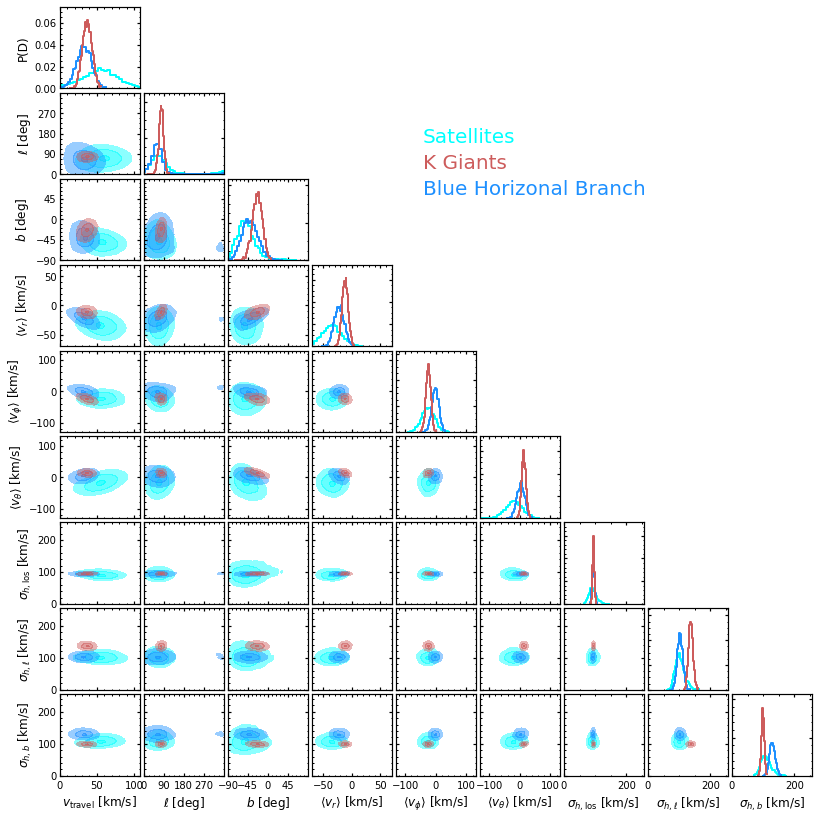

In [49]:

mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True


mpl.rcParams['xtick.major.size'] = 3.
mpl.rcParams['xtick.minor.size'] = 1.5
mpl.rcParams['ytick.major.size'] = 3.
mpl.rcParams['ytick.minor.size'] = 1.5


usecats = ['vtravel','phi','theta','vra','vphi','vth','sigmar','sigmap','sigmat']

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

decoded = ['$v_{\\rm travel}$ [km/s]','$\ell$ [deg]','$b$ [deg]',\
           '$\\langle v_r\\rangle$ [km/s]','$\\langle v_{\\phi}\\rangle $ [km/s]','$\\langle v_{\\theta}\\rangle$ [km/s]',\
          '$\\sigma_{h,{\\rm los}}$ [km/s]','$\\sigma_{h,\ell}$ [km/s]','$\\sigma_{h,b}$ [km/s]']


dictnames = [BHB,SAT,KGiants,ALL]
colorlist = ['dodgerblue','cyan','indianred','silver']


dictnames = [SAT,BHB,KGiants]
colorlist = ['cyan','dodgerblue','indianred']


# override angular bounddict coordinates to be homogeneous
bounddict['phi'] = [-180.,180.]
bounddict['phi'] = [0.,360.]
bounddict['theta'] = [-90.,90]
bounddict['vra'] = [-70.,70.]
bounddict['vphi'] = [-130.,130.]
bounddict['vth'] = [-130.,130.]

bounddict['sigmat'] = [0.,255.]
bounddict['sigmap'] = [0.,255.]
bounddict['sigmar'] = [0.,255.]



fig = plt.figure(figsize=(12,12))

xmin = 0.08
ymin = 0.07
ncats = len(usecats)
ncats1 = len(usecats)-1
dx = 0.83/ncats
dy = 0.85/ncats
buf = 0.005

binset = [75.,92.,99.5]

for u1i,u1 in enumerate(usecats):
    for u2i,u2 in enumerate(usecats):
        if u2i>u1i: continue
        if u2==u1: continue
        print(ncats-u1i,u2i,u1,u2)
        # u2i is the col
        # u1i is the row
        ax = fig.add_axes([xmin+u2i*(dx+buf),ymin+(ncats-u1i-1)*(dy+buf),dx,dy])
        
        inbounds = [bounddict[u2][0],bounddict[u2][1],\
                 bounddict[u1][0],bounddict[u1][1]]
        #xx,yy,dens,dadb = make_banana(SAT[u2],SAT[u1])
        for idict,dictname in enumerate(dictnames):
            if dictname==ALL:
                plot_banana(ax,dictname,u2,u1,colorlist[idict],border=True,binset=binset)

            elif dictname==SAT:
                if ((u1=='theta')|(u2=='theta')):
                    plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,bounds=inbounds,binset=[85.,94.,99.5],alphashade=0.15,alphazero=0.3)
                else:
                    plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,binset=[85.,94.,99.5],alphashade=0.15,alphazero=0.3)
                
            else:
                plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,binset=binset,alphashade=0.15,alphazero=0.3)


        if (ncats-u1i-1)==0:
            ax.set_xlabel(decoded[u2i],size=12)
        else:
            ax.set_xticklabels(())
            
        if (u2i)==0:
            ax.set_ylabel(decoded[u1i],size=12)
        else:
            ax.set_yticklabels(())
            
        ax.axis(inbounds)
        
        if (u1=='phi'):
            ax.set_yticks([0.,90.,180.,270.])
            
        if (u2=='phi'):
            ax.set_xticks([0.,90.,180.,270.])
        
        if (u1=='theta'):
            ax.set_yticks([-90.,-45.,0.,45.])            
    
        if (u2=='theta'):
            ax.set_xticks([-90.,-45.,0.,45.])
        
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis="y",which='both',direction="in")
        ax.tick_params(axis="x",which='both',direction="in",pad=5)
        

for u1i,u1 in enumerate(usecats):
    ax = fig.add_axes([xmin+u1i*(dx+buf),ymin+(ncats-u1i-1)*(dy+buf),dx,dy])

    for idict,dictname in enumerate(dictnames):
        A,B = norm_histogram(dictname[u1],bins=30)

        ax.plot(A,B,color=colorlist[idict],linestyle='steps-mid')
        
    ax.axis([bounddict[u1][0],bounddict[u1][1],0.,0.12])
    
    ax.axis([bounddict[u1][0],bounddict[u1][1],0.,1.2*np.nanmax(B)])

    if (u1=='phi'):
        ax.set_xticks([0.,90.,180.,270.])
    if (u1=='theta'):
        ax.set_xticks([-90.,-45.,0.,45.])
        
    if (ncats-u1i-1)>0:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel(decoded[u1i],size=12)
    
    if u1i!=0:
        ax.set_yticklabels(())
    else:
        ax.set_ylabel('P(D)',size=12)
        
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)
    
 
tsize = 20

plt.text( 0.5, 0.76, 'Blue Horizonal Branch', color='dodgerblue',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.79, 'K Giants', color='indianred',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.82, 'Satellites', color='cyan',size=tsize,ha='left', va='top', transform=fig.transFigure ) 

#plt.savefig('figures/suppFigure_filtered.png',dpi=300)
plt.savefig('figures/suppFigure_minimum_mcconnachie_40.png',dpi=300)






In [42]:


mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True

usecats = ['vtravel','phi','theta','vra','vphi','vth','sigmar','sigmap','sigmat']

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

decoded = ['$v_{\\rm travel}$ [km/s]','$\ell$ [deg]','$b$ [deg]',\
           '$\\langle v_r\\rangle$ [km/s]','$\\langle v_{\\phi}\\rangle $ [km/s]','$\\langle v_{\\theta}\\rangle$ [km/s]',\
          '$\\sigma_{h,{\\rm los}}$ [km/s]','$\\sigma_{h,\ell}$ [km/s]','$\\sigma_{h,b}$ [km/s]']


dictnames = [KGiants9,KGiants,KGiants11]
colorlist = ['lightcoral','indianred','darkred']


#dictnames = [BHB9,BHB,BHB11]
#colorlist = ['skyblue','dodgerblue','darkblue']

dictnames = [ALL9,ALL,ALL11]
colorlist = ['silver','grey','black']





# override angular bounddict coordinates
bounddict['phi'] = [-180.,180.]
bounddict['phi'] = [0.,360.]
bounddict['theta'] = [-90.,90]
bounddict['vra'] = [-70.,70.]
bounddict['vphi'] = [-130.,130.]
bounddict['vth'] = [-130.,130.]

bounddict['sigmat'] = [0.,255.]
bounddict['sigmap'] = [0.,255.]
bounddict['sigmar'] = [0.,255.]





fig = plt.figure(figsize=(12,12))

xmin = 0.08
ymin = 0.07
ncats = len(usecats)
ncats1 = len(usecats)-1
dx = 0.83/ncats
dy = 0.85/ncats
buf = 0.005

binset = [75.,92.,99.5]

for u1i,u1 in enumerate(usecats):
    for u2i,u2 in enumerate(usecats):
        if u2i>u1i: continue
        if u2==u1: continue
        print(ncats-u1i,u2i,u1,u2)
        # u2i is the col
        # u1i is the row
        ax = fig.add_axes([xmin+u2i*(dx+buf),ymin+(ncats-u1i-1)*(dy+buf),dx,dy])
        
        inbounds = [bounddict[u2][0],bounddict[u2][1],\
                 bounddict[u1][0],bounddict[u1][1]]
        #xx,yy,dens,dadb = make_banana(SAT[u2],SAT[u1])
        for idict,dictname in enumerate(dictnames):
            if dictname==ALL:
                plot_banana(ax,dictname,u2,u1,colorlist[idict],border=True,binset=binset)

            elif dictname==SAT:
                if ((u1=='theta')|(u2=='theta')):
                    plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,bounds=inbounds,binset=[85.,94.,99.5],alphashade=0.15,alphazero=0.3)
                else:
                    plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,binset=[85.,94.,99.5],alphashade=0.15,alphazero=0.3)
                
            else:
                plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,binset=binset,alphashade=0.15,alphazero=0.3)
        
        if (ncats-u1i-1)==0:
            ax.set_xlabel(decoded[u2i],size=12)
        else:
            ax.set_xticklabels(())
            
        if (u2i)==0:
            ax.set_ylabel(decoded[u1i],size=12)
        else:
            ax.set_yticklabels(())
            
        ax.axis(inbounds)
        
        if (u1=='phi'):
            ax.set_yticks([0.,90.,180.,270.])
            
        if (u2=='phi'):
            ax.set_xticks([0.,90.,180.,270.])
        
        if (u1=='theta'):
            ax.set_yticks([-90.,-45.,0.,45.])            
    
        if (u2=='theta'):
            ax.set_xticks([-90.,-45.,0.,45.])
        
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis="y",which='both',direction="in")
        ax.tick_params(axis="x",which='both',direction="in",pad=5)
        

for u1i,u1 in enumerate(usecats):
    ax = fig.add_axes([xmin+u1i*(dx+buf),ymin+(ncats-u1i-1)*(dy+buf),dx,dy])

    for idict,dictname in enumerate(dictnames):
        A,B = norm_histogram(dictname[u1],bins=30)

        ax.plot(A,B,color=colorlist[idict],linestyle='steps-mid')
        
    ax.axis([bounddict[u1][0],bounddict[u1][1],0.,0.12])
    
    ax.axis([bounddict[u1][0],bounddict[u1][1],0.,1.2*np.nanmax(B)])

    if (u1=='phi'):
        ax.set_xticks([0.,90.,180.,270.])
    if (u1=='theta'):
        ax.set_xticks([-90.,-45.,0.,45.])
        
    if (ncats-u1i-1)>0:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel(decoded[u1i],size=12)
    
    if u1i!=0:
        ax.set_yticklabels(())
    else:
        ax.set_ylabel('P(D)',size=12)
        
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)
    
#dictnames = [BHB,KGiants,SAT,ALL]
#colorlist = ['blue','red','cyan','black']

        
tsize = 20

#plt.text( 0.5, 0.82, 'Blue horizonal branch ($\\times$1)', color='dodgerblue',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
#plt.text( 0.5, 0.79, 'Blue horizonal branch ($\\times$0.9)', color='skyblue',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
#plt.text( 0.5, 0.76, 'Blue horizonal branch ($\\times$1.1)', color='darkblue',size=tsize,ha='left', va='top', transform=fig.transFigure ) 

#plt.text( 0.5, 0.82, 'K Giants ($\\times$1)', color='indianred',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
#plt.text( 0.5, 0.79, 'K Giants ($\\times$0.9)', color='lightcoral',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
#plt.text( 0.5, 0.76, 'K Giants ($\\times$1.1)', color='darkred',size=tsize,ha='left', va='top', transform=fig.transFigure ) 

plt.text( 0.5, 0.82, 'Combined ($\\times$1)', color='grey',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.79, 'Combined ($\\times$0.9)', color='silver',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.76, 'Combined ($\\times$1.1)', color='black',size=tsize,ha='left', va='top', transform=fig.transFigure ) 



#plt.text( 0.5, 0.75, 'GCs', color='green',size=tsize,ha='left', va='top', transform=fig.transFigure ) 





#plt.savefig('/Users/mpetersen/Dropbox/mike/analysis/corner_noRRL_d050150.png',dpi=300)
#plt.savefig('/Users/mpetersen/Dropbox/mike/analysis/corner_d050150.png',dpi=300)

#plt.savefig('/Users/mpetersen/Dropbox/mike/analysis/corner_BHB_K_d035150.png',dpi=300)

#plt.savefig('/Users/mpetersen/Downloads/corner_noRRL_d035150.png',dpi=300)

#plt.savefig('/Users/mpetersen/Dropbox/mike/analysis/corner_all_sats_d050150.png',dpi=300)


#plt.savefig('/Users/mpetersen/Dropbox/mike/analysis/corner_all_sats_GC8_d050150.png',dpi=300)

#plt.savefig('/Users/mpetersen/Downloads/comp_dist_bhb_dcorr.png',dpi=300)
#plt.savefig('/Users/mpetersen/Downloads/comp_dist_kgiant_dcorr.png',dpi=300)
plt.savefig('/Users/mpetersen/Downloads/comp_dist_all_dcorr.png',dpi=300)


#plt.savefig('/Users/mpetersen/Dropbox/mike/data/suppFigure_dcorr.png',dpi=300)








NameError: name 'KGiants9' is not defined

8 0 phi vtravel
7 0 theta vtravel
7 1 theta phi
6 0 vra vtravel
6 1 vra phi
6 2 vra theta
5 0 vphi vtravel
5 1 vphi phi
5 2 vphi theta
5 3 vphi vra
4 0 vth vtravel
4 1 vth phi
4 2 vth theta
4 3 vth vra
4 4 vth vphi
3 0 sigmar vtravel
3 1 sigmar phi
3 2 sigmar theta
3 3 sigmar vra
3 4 sigmar vphi
3 5 sigmar vth
2 0 sigmap vtravel
2 1 sigmap phi
2 2 sigmap theta
2 3 sigmap vra
2 4 sigmap vphi
2 5 sigmap vth
2 6 sigmap sigmar
1 0 sigmat vtravel
1 1 sigmat phi
1 2 sigmat theta
1 3 sigmat vra
1 4 sigmat vphi
1 5 sigmat vth
1 6 sigmat sigmar
1 7 sigmat sigmap


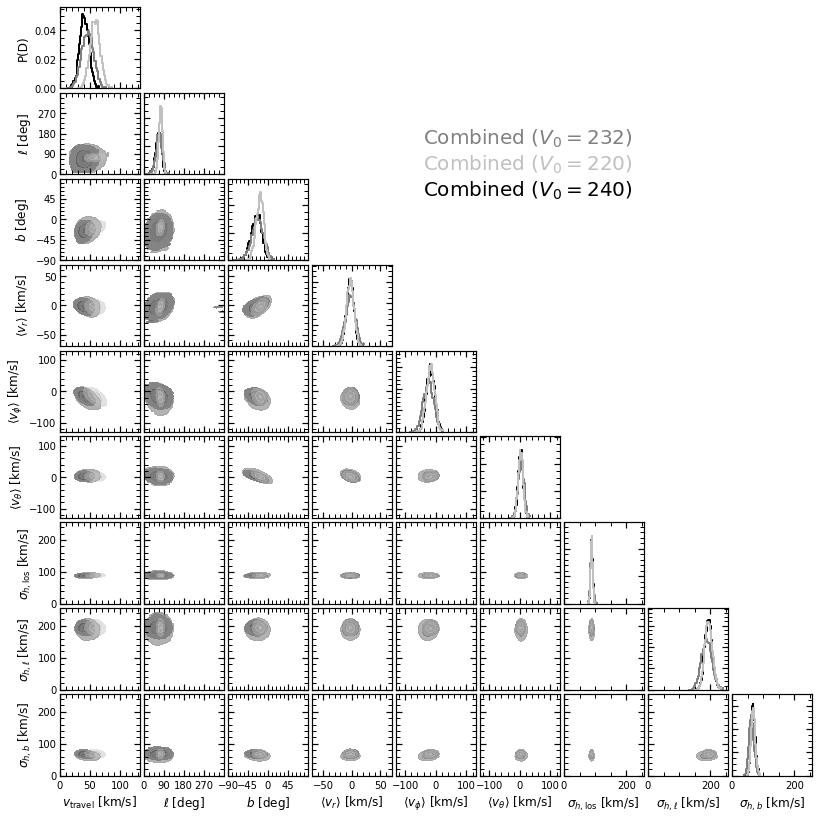

In [300]:


mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True

usecats = ['vtravel','phi','theta','vra','vphi','vth','sigmar','sigmap','sigmat']

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

decoded = ['$v_{\\rm travel}$ [km/s]','$\ell$ [deg]','$b$ [deg]',\
           '$\\langle v_r\\rangle$ [km/s]','$\\langle v_{\\phi}\\rangle $ [km/s]','$\\langle v_{\\theta}\\rangle$ [km/s]',\
          '$\\sigma_{h,{\\rm los}}$ [km/s]','$\\sigma_{h,\ell}$ [km/s]','$\\sigma_{h,b}$ [km/s]']


dictnames = [KGiants240,KGiants,KGiants220]
colorlist = ['darkred','indianred','lightcoral']


#dictnames = [BHB,BHB220]#,BHB11]
#colorlist = ['dodgerblue','skyblue','darkblue']

dictnames = [ALL240,ALL,ALL220]#,ALL11]
colorlist = ['black','grey','silver']





# override angular bounddict coordinates
bounddict['phi'] = [-180.,180.]
bounddict['phi'] = [0.,360.]
bounddict['theta'] = [-90.,90]
bounddict['vra'] = [-70.,70.]
bounddict['vphi'] = [-130.,130.]
bounddict['vth'] = [-130.,130.]

bounddict['sigmat'] = [0.,255.]
bounddict['sigmap'] = [0.,255.]
bounddict['sigmar'] = [0.,255.]





fig = plt.figure(figsize=(12,12))

xmin = 0.08
ymin = 0.07
ncats = len(usecats)
ncats1 = len(usecats)-1
dx = 0.83/ncats
dy = 0.85/ncats
buf = 0.005

binset = [75.,92.,99.5]

for u1i,u1 in enumerate(usecats):
    for u2i,u2 in enumerate(usecats):
        if u2i>u1i: continue
        if u2==u1: continue
        print(ncats-u1i,u2i,u1,u2)
        # u2i is the col
        # u1i is the row
        ax = fig.add_axes([xmin+u2i*(dx+buf),ymin+(ncats-u1i-1)*(dy+buf),dx,dy])
        
        inbounds = [bounddict[u2][0],bounddict[u2][1],\
                 bounddict[u1][0],bounddict[u1][1]]
        #xx,yy,dens,dadb = make_banana(SAT[u2],SAT[u1])
        for idict,dictname in enumerate(dictnames):
            if dictname==ALL:
                plot_banana(ax,dictname,u2,u1,colorlist[idict],border=True,binset=binset)

            elif dictname==SAT:
                if ((u1=='theta')|(u2=='theta')):
                    plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,bounds=inbounds,binset=[85.,94.,99.5],alphashade=0.15,alphazero=0.3)
                else:
                    plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,binset=[85.,94.,99.5],alphashade=0.15,alphazero=0.3)
                
            else:
                plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,binset=binset,alphashade=0.15,alphazero=0.3)
        
        if (ncats-u1i-1)==0:
            ax.set_xlabel(decoded[u2i],size=12)
        else:
            ax.set_xticklabels(())
            
        if (u2i)==0:
            ax.set_ylabel(decoded[u1i],size=12)
        else:
            ax.set_yticklabels(())
            
        ax.axis(inbounds)
        
        if (u1=='phi'):
            ax.set_yticks([0.,90.,180.,270.])
            
        if (u2=='phi'):
            ax.set_xticks([0.,90.,180.,270.])
        
        if (u1=='theta'):
            ax.set_yticks([-90.,-45.,0.,45.])            
    
        if (u2=='theta'):
            ax.set_xticks([-90.,-45.,0.,45.])
        
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis="y",which='both',direction="in")
        ax.tick_params(axis="x",which='both',direction="in",pad=5)
        

for u1i,u1 in enumerate(usecats):
    ax = fig.add_axes([xmin+u1i*(dx+buf),ymin+(ncats-u1i-1)*(dy+buf),dx,dy])

    for idict,dictname in enumerate(dictnames):
        A,B = norm_histogram(dictname[u1],bins=30)

        ax.plot(A,B,color=colorlist[idict],linestyle='steps-mid')
        
    ax.axis([bounddict[u1][0],bounddict[u1][1],0.,0.12])
    
    ax.axis([bounddict[u1][0],bounddict[u1][1],0.,1.2*np.nanmax(B)])

    if (u1=='phi'):
        ax.set_xticks([0.,90.,180.,270.])
    if (u1=='theta'):
        ax.set_xticks([-90.,-45.,0.,45.])
        
    if (ncats-u1i-1)>0:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel(decoded[u1i],size=12)
    
    if u1i!=0:
        ax.set_yticklabels(())
    else:
        ax.set_ylabel('P(D)',size=12)
        
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)
    
#dictnames = [BHB,KGiants,SAT,ALL]
#colorlist = ['blue','red','cyan','black']

        
tsize = 20

#plt.text( 0.5, 0.82, 'Blue horizonal branch ($V_0=232$)', color='dodgerblue',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
#plt.text( 0.5, 0.79, 'Blue horizonal branch ($V_0=220$)', color='skyblue',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
#plt.text( 0.5, 0.76, 'Blue horizonal branch ($\\times$1.1)', color='darkblue',size=tsize,ha='left', va='top', transform=fig.transFigure ) 

#plt.text( 0.5, 0.82, 'K Giants ($V_0=232$)', color='indianred',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
#plt.text( 0.5, 0.79, 'K Giants ($V_0=220$)', color='lightcoral',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
#plt.text( 0.5, 0.76, 'K Giants ($V_0=240$)', color='darkred',size=tsize,ha='left', va='top', transform=fig.transFigure ) 

plt.text( 0.5, 0.82, 'Combined ($V_0=232$)', color='grey',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.79, 'Combined ($V_0=220$)', color='silver',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.76, 'Combined ($V_0=240$)', color='black',size=tsize,ha='left', va='top', transform=fig.transFigure ) 



#plt.text( 0.5, 0.75, 'GCs', color='green',size=tsize,ha='left', va='top', transform=fig.transFigure ) 




#plt.savefig('/Users/mpetersen/Downloads/comp_dist_bhb_v0220.png',dpi=300)
#plt.savefig('/Users/mpetersen/Downloads/comp_dist_kgiant_v0220.png',dpi=300)
#plt.savefig('/Users/mpetersen/Downloads/comp_dist_all_v0220.png',dpi=300)











8 0 phi vtravel
7 0 theta vtravel
7 1 theta phi
6 0 vra vtravel
6 1 vra phi
6 2 vra theta
5 0 vphi vtravel
5 1 vphi phi
5 2 vphi theta
5 3 vphi vra
4 0 vth vtravel
4 1 vth phi
4 2 vth theta
4 3 vth vra
4 4 vth vphi
3 0 sigmar vtravel
3 1 sigmar phi
3 2 sigmar theta
3 3 sigmar vra
3 4 sigmar vphi
3 5 sigmar vth
2 0 sigmap vtravel
2 1 sigmap phi
2 2 sigmap theta
2 3 sigmap vra
2 4 sigmap vphi
2 5 sigmap vth
2 6 sigmap sigmar
1 0 sigmat vtravel
1 1 sigmat phi
1 2 sigmat theta
1 3 sigmat vra
1 4 sigmat vphi
1 5 sigmat vth
1 6 sigmat sigmar
1 7 sigmat sigmap


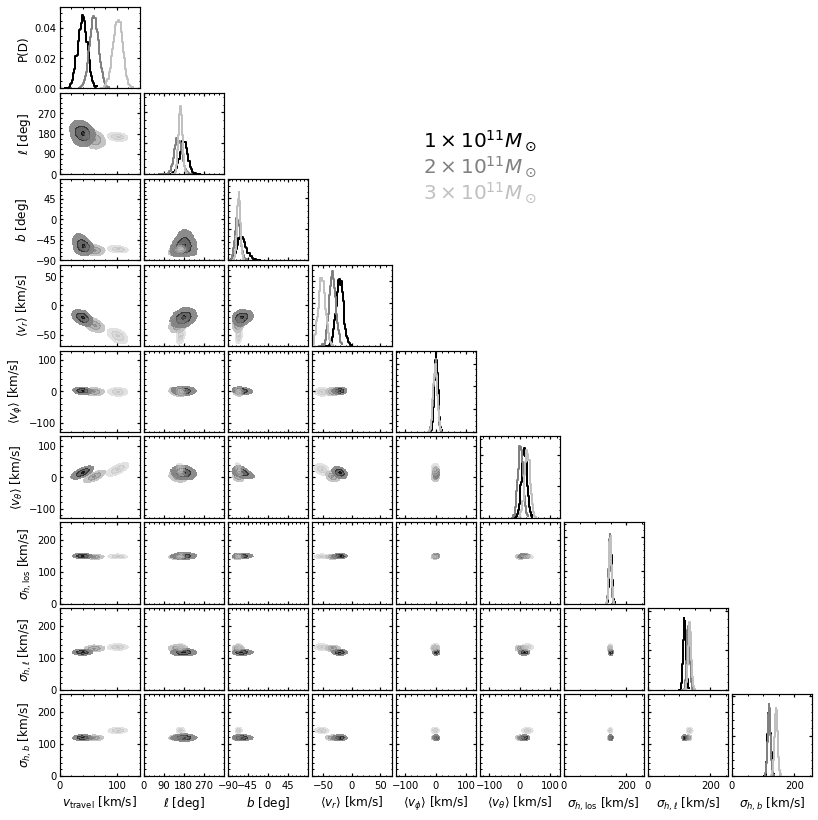

In [27]:


mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True

usecats = ['vtravel','phi','theta','vra','vphi','vth','sigmar','sigmap','sigmat']

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

decoded = ['$v_{\\rm travel}$ [km/s]','$\ell$ [deg]','$b$ [deg]',\
           '$\\langle v_r\\rangle$ [km/s]','$\\langle v_{\\phi}\\rangle $ [km/s]','$\\langle v_{\\theta}\\rangle$ [km/s]',\
          '$\\sigma_{h,{\\rm los}}$ [km/s]','$\\sigma_{h,\ell}$ [km/s]','$\\sigma_{h,b}$ [km/s]']


dictnames = [S13,S14,S15]
colorlist = ['black','grey','silver']





# override angular bounddict coordinates
bounddict['vtravel'] = [0.,140.]
bounddict['phi'] = [-180.,180.]
bounddict['phi'] = [0.,360.]
bounddict['theta'] = [-90.,90]
bounddict['vra'] = [-70.,70.]
bounddict['vphi'] = [-130.,130.]
bounddict['vth'] = [-130.,130.]

bounddict['sigmat'] = [0.,255.]
bounddict['sigmap'] = [0.,255.]
bounddict['sigmar'] = [0.,255.]





fig = plt.figure(figsize=(12,12))

xmin = 0.08
ymin = 0.07
ncats = len(usecats)
ncats1 = len(usecats)-1
dx = 0.83/ncats
dy = 0.85/ncats
buf = 0.005

binset = [75.,92.,99.5]

for u1i,u1 in enumerate(usecats):
    for u2i,u2 in enumerate(usecats):
        if u2i>u1i: continue
        if u2==u1: continue
        print(ncats-u1i,u2i,u1,u2)
        # u2i is the col
        # u1i is the row
        ax = fig.add_axes([xmin+u2i*(dx+buf),ymin+(ncats-u1i-1)*(dy+buf),dx,dy])
        
        inbounds = [bounddict[u2][0],bounddict[u2][1],\
                 bounddict[u1][0],bounddict[u1][1]]
        #xx,yy,dens,dadb = make_banana(SAT[u2],SAT[u1])
        for idict,dictname in enumerate(dictnames):
            if dictname==ALL:
                plot_banana(ax,dictname,u2,u1,colorlist[idict],border=True,binset=binset)

            elif dictname==SAT:
                if ((u1=='theta')|(u2=='theta')):
                    plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,bounds=inbounds,binset=[85.,94.,99.5],alphashade=0.15,alphazero=0.3)
                else:
                    plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,binset=[85.,94.,99.5],alphashade=0.15,alphazero=0.3)
                
            else:
                plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,binset=binset,alphashade=0.15,alphazero=0.3)
        
        if (ncats-u1i-1)==0:
            ax.set_xlabel(decoded[u2i],size=12)
        else:
            ax.set_xticklabels(())
            
        if (u2i)==0:
            ax.set_ylabel(decoded[u1i],size=12)
        else:
            ax.set_yticklabels(())
            
        ax.axis(inbounds)
        
        if (u1=='phi'):
            ax.set_yticks([0.,90.,180.,270.])
            
        if (u2=='phi'):
            ax.set_xticks([0.,90.,180.,270.])
        
        if (u1=='theta'):
            ax.set_yticks([-90.,-45.,0.,45.])            
    
        if (u2=='theta'):
            ax.set_xticks([-90.,-45.,0.,45.])
        
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis="y",which='both',direction="in")
        ax.tick_params(axis="x",which='both',direction="in",pad=5)
        

for u1i,u1 in enumerate(usecats):
    ax = fig.add_axes([xmin+u1i*(dx+buf),ymin+(ncats-u1i-1)*(dy+buf),dx,dy])

    for idict,dictname in enumerate(dictnames):
        A,B = norm_histogram(dictname[u1],bins=30)

        ax.plot(A,B,color=colorlist[idict],linestyle='steps-mid')
        
    ax.axis([bounddict[u1][0],bounddict[u1][1],0.,0.12])
    
    ax.axis([bounddict[u1][0],bounddict[u1][1],0.,1.2*np.nanmax(B)])

    if (u1=='phi'):
        ax.set_xticks([0.,90.,180.,270.])
    if (u1=='theta'):
        ax.set_xticks([-90.,-45.,0.,45.])
        
    if (ncats-u1i-1)>0:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel(decoded[u1i],size=12)
    
    if u1i!=0:
        ax.set_yticklabels(())
    else:
        ax.set_ylabel('P(D)',size=12)
        
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)
    
   
tsize = 20


plt.text( 0.5, 0.82, '$1\\times10^{11}M_\odot$', color='black',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.79, '$2\\times10^{11}M_\odot$', color='grey',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.76, '$3\\times10^{11}M_\odot$', color='silver',size=tsize,ha='left', va='top', transform=fig.transFigure ) 



plt.savefig('figures/mock_comp.png',dpi=300)












In [311]:
print(np.nanmedian(KGiantsPoor['sigmap']))

331.597087303256


8 0 phi vtravel
7 0 theta vtravel
7 1 theta phi
6 0 vra vtravel
6 1 vra phi
6 2 vra theta
5 0 vphi vtravel
5 1 vphi phi
5 2 vphi theta
5 3 vphi vra
4 0 vth vtravel
4 1 vth phi
4 2 vth theta
4 3 vth vra
4 4 vth vphi
3 0 sigmar vtravel
3 1 sigmar phi
3 2 sigmar theta
3 3 sigmar vra
3 4 sigmar vphi
3 5 sigmar vth
2 0 sigmap vtravel
2 1 sigmap phi
2 2 sigmap theta
2 3 sigmap vra
2 4 sigmap vphi
2 5 sigmap vth
2 6 sigmap sigmar
1 0 sigmat vtravel
1 1 sigmat phi
1 2 sigmat theta
1 3 sigmat vra
1 4 sigmat vphi
1 5 sigmat vth
1 6 sigmat sigmar
1 7 sigmat sigmap


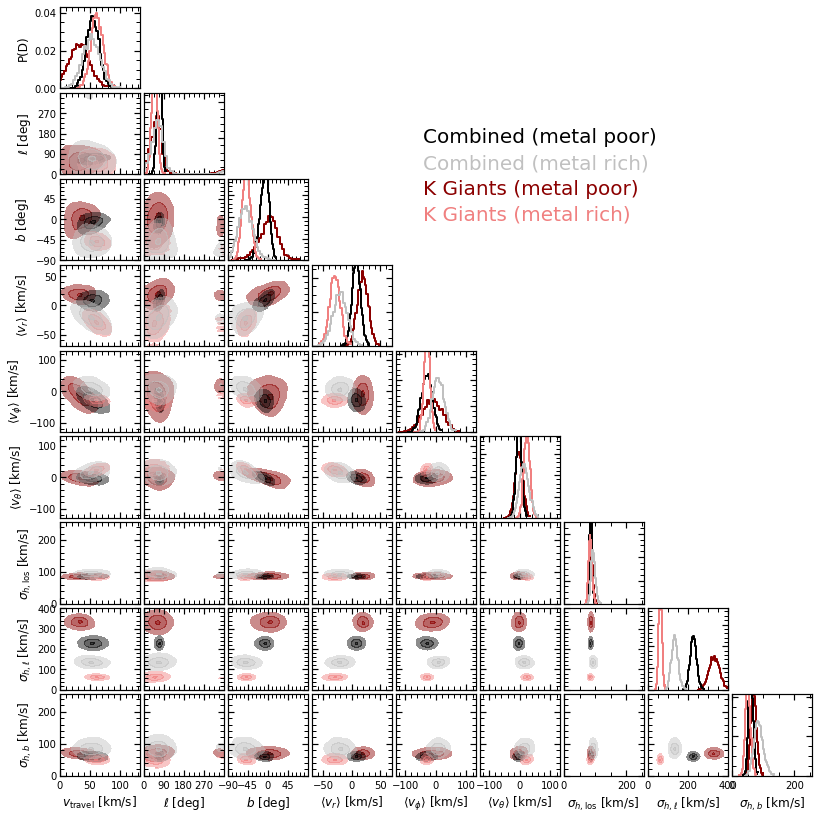

In [312]:


mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True

usecats = ['vtravel','phi','theta','vra','vphi','vth','sigmar','sigmap','sigmat']

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

decoded = ['$v_{\\rm travel}$ [km/s]','$\ell$ [deg]','$b$ [deg]',\
           '$\\langle v_r\\rangle$ [km/s]','$\\langle v_{\\phi}\\rangle $ [km/s]','$\\langle v_{\\theta}\\rangle$ [km/s]',\
          '$\\sigma_{h,{\\rm los}}$ [km/s]','$\\sigma_{h,\ell}$ [km/s]','$\\sigma_{h,b}$ [km/s]']


dictnames = [KGiantsPoor,AllPoor,KGiantsRich,AllRich]
colorlist = ['darkred','black','lightcoral','silver']





# override angular bounddict coordinates
bounddict['phi'] = [-180.,180.]
bounddict['phi'] = [0.,360.]
bounddict['theta'] = [-90.,90]
bounddict['vra'] = [-70.,70.]
bounddict['vphi'] = [-130.,130.]
bounddict['vth'] = [-130.,130.]

bounddict['sigmat'] = [0.,255.]
bounddict['sigmap'] = [0.,400.]
bounddict['sigmar'] = [0.,255.]





fig = plt.figure(figsize=(12,12))

xmin = 0.08
ymin = 0.07
ncats = len(usecats)
ncats1 = len(usecats)-1
dx = 0.83/ncats
dy = 0.85/ncats
buf = 0.005

binset = [75.,92.,99.5]

for u1i,u1 in enumerate(usecats):
    for u2i,u2 in enumerate(usecats):
        if u2i>u1i: continue
        if u2==u1: continue
        print(ncats-u1i,u2i,u1,u2)
        # u2i is the col
        # u1i is the row
        ax = fig.add_axes([xmin+u2i*(dx+buf),ymin+(ncats-u1i-1)*(dy+buf),dx,dy])
        
        inbounds = [bounddict[u2][0],bounddict[u2][1],\
                 bounddict[u1][0],bounddict[u1][1]]
        #xx,yy,dens,dadb = make_banana(SAT[u2],SAT[u1])
        for idict,dictname in enumerate(dictnames):
            if dictname==ALL:
                plot_banana(ax,dictname,u2,u1,colorlist[idict],border=True,binset=binset)

            elif dictname==SAT:
                if ((u1=='theta')|(u2=='theta')):
                    plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,bounds=inbounds,binset=[85.,94.,99.5],alphashade=0.15,alphazero=0.3)
                else:
                    plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,binset=[85.,94.,99.5],alphashade=0.15,alphazero=0.3)
                
            else:
                plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,binset=binset,alphashade=0.15,alphazero=0.3)
        
        if (ncats-u1i-1)==0:
            ax.set_xlabel(decoded[u2i],size=12)
        else:
            ax.set_xticklabels(())
            
        if (u2i)==0:
            ax.set_ylabel(decoded[u1i],size=12)
        else:
            ax.set_yticklabels(())
            
        ax.axis(inbounds)
        
        if (u1=='phi'):
            ax.set_yticks([0.,90.,180.,270.])
            
        if (u2=='phi'):
            ax.set_xticks([0.,90.,180.,270.])
        
        if (u1=='theta'):
            ax.set_yticks([-90.,-45.,0.,45.])            
    
        if (u2=='theta'):
            ax.set_xticks([-90.,-45.,0.,45.])
        
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis="y",which='both',direction="in")
        ax.tick_params(axis="x",which='both',direction="in",pad=5)
        

for u1i,u1 in enumerate(usecats):
    ax = fig.add_axes([xmin+u1i*(dx+buf),ymin+(ncats-u1i-1)*(dy+buf),dx,dy])

    for idict,dictname in enumerate(dictnames):
        A,B = norm_histogram(dictname[u1],bins=30)

        ax.plot(A,B,color=colorlist[idict],linestyle='steps-mid')
        
    ax.axis([bounddict[u1][0],bounddict[u1][1],0.,0.12])
    
    ax.axis([bounddict[u1][0],bounddict[u1][1],0.,1.5*np.nanmax(B)])

    if (u1=='phi'):
        ax.set_xticks([0.,90.,180.,270.])
    if (u1=='theta'):
        ax.set_xticks([-90.,-45.,0.,45.])
        
    if (ncats-u1i-1)>0:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel(decoded[u1i],size=12)
    
    if u1i!=0:
        ax.set_yticklabels(())
    else:
        ax.set_ylabel('P(D)',size=12)
        
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)
    
  
tsize = 20

plt.text( 0.5, 0.82, 'Combined (metal poor)', color='black',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.79, 'Combined (metal rich)', color='silver',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.76, 'K Giants (metal poor)', color='darkred',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.73, 'K Giants (metal rich)', color='lightcoral',size=tsize,ha='left', va='top', transform=fig.transFigure ) 



plt.savefig('/Users/mpetersen/Downloads/comp_metals.png',dpi=300)










8 0 phi vtravel
7 0 theta vtravel
7 1 theta phi
6 0 vra vtravel
6 1 vra phi
6 2 vra theta
5 0 vphi vtravel
5 1 vphi phi
5 2 vphi theta
5 3 vphi vra
4 0 vth vtravel
4 1 vth phi
4 2 vth theta
4 3 vth vra
4 4 vth vphi
3 0 sigmar vtravel
3 1 sigmar phi
3 2 sigmar theta
3 3 sigmar vra
3 4 sigmar vphi
3 5 sigmar vth
2 0 sigmap vtravel
2 1 sigmap phi
2 2 sigmap theta
2 3 sigmap vra
2 4 sigmap vphi
2 5 sigmap vth
2 6 sigmap sigmar
1 0 sigmat vtravel
1 1 sigmat phi
1 2 sigmat theta
1 3 sigmat vra
1 4 sigmat vphi
1 5 sigmat vth
1 6 sigmat sigmar
1 7 sigmat sigmap


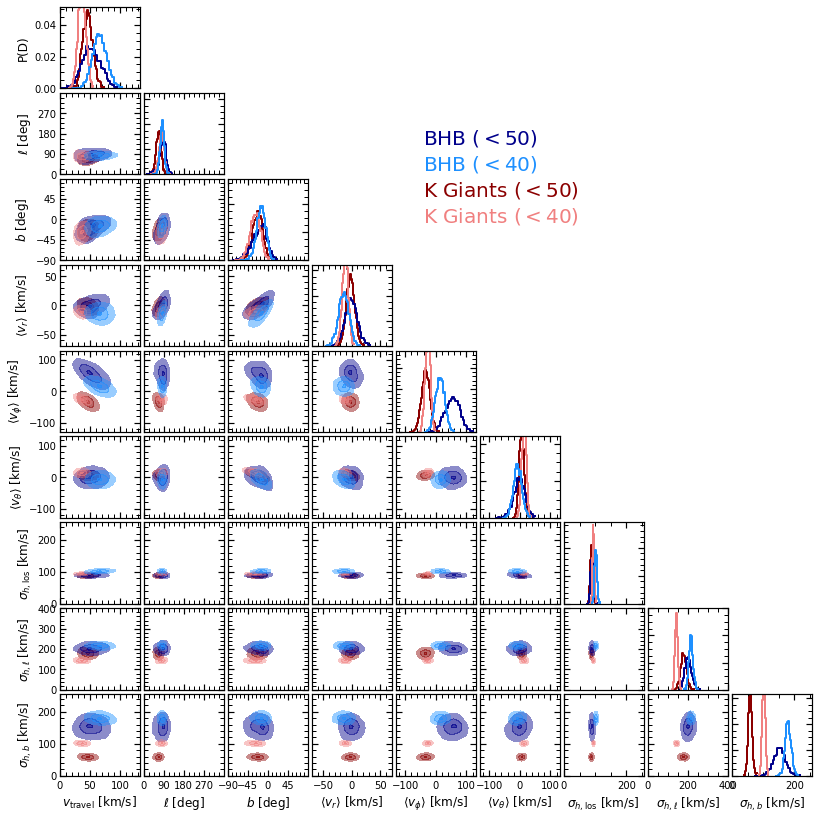

In [328]:


mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True

usecats = ['vtravel','phi','theta','vra','vphi','vth','sigmar','sigmap','sigmat']

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

decoded = ['$v_{\\rm travel}$ [km/s]','$\ell$ [deg]','$b$ [deg]',\
           '$\\langle v_r\\rangle$ [km/s]','$\\langle v_{\\phi}\\rangle $ [km/s]','$\\langle v_{\\theta}\\rangle$ [km/s]',\
          '$\\sigma_{h,{\\rm los}}$ [km/s]','$\\sigma_{h,\ell}$ [km/s]','$\\sigma_{h,b}$ [km/s]']


dictnames = [KGiants,BHB,KGiants40,BHB40]
colorlist = ['darkred','darkblue','lightcoral','dodgerblue']





# override angular bounddict coordinates
bounddict['phi'] = [-180.,180.]
bounddict['phi'] = [0.,360.]
bounddict['theta'] = [-90.,90]
bounddict['vra'] = [-70.,70.]
bounddict['vphi'] = [-130.,130.]
bounddict['vth'] = [-130.,130.]

bounddict['sigmat'] = [0.,255.]
bounddict['sigmap'] = [0.,400.]
bounddict['sigmar'] = [0.,255.]





fig = plt.figure(figsize=(12,12))

xmin = 0.08
ymin = 0.07
ncats = len(usecats)
ncats1 = len(usecats)-1
dx = 0.83/ncats
dy = 0.85/ncats
buf = 0.005

binset = [75.,92.,99.5]

for u1i,u1 in enumerate(usecats):
    for u2i,u2 in enumerate(usecats):
        if u2i>u1i: continue
        if u2==u1: continue
        print(ncats-u1i,u2i,u1,u2)
        # u2i is the col
        # u1i is the row
        ax = fig.add_axes([xmin+u2i*(dx+buf),ymin+(ncats-u1i-1)*(dy+buf),dx,dy])
        
        inbounds = [bounddict[u2][0],bounddict[u2][1],\
                 bounddict[u1][0],bounddict[u1][1]]
        #xx,yy,dens,dadb = make_banana(SAT[u2],SAT[u1])
        for idict,dictname in enumerate(dictnames):
            if dictname==ALL:
                plot_banana(ax,dictname,u2,u1,colorlist[idict],border=True,binset=binset)

            elif dictname==SAT:
                if ((u1=='theta')|(u2=='theta')):
                    plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,bounds=inbounds,binset=[85.,94.,99.5],alphashade=0.15,alphazero=0.3)
                else:
                    plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,binset=[85.,94.,99.5],alphashade=0.15,alphazero=0.3)
                
            else:
                plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,binset=binset,alphashade=0.15,alphazero=0.3)
        
        if (ncats-u1i-1)==0:
            ax.set_xlabel(decoded[u2i],size=12)
        else:
            ax.set_xticklabels(())
            
        if (u2i)==0:
            ax.set_ylabel(decoded[u1i],size=12)
        else:
            ax.set_yticklabels(())
            
        ax.axis(inbounds)
        
        if (u1=='phi'):
            ax.set_yticks([0.,90.,180.,270.])
            
        if (u2=='phi'):
            ax.set_xticks([0.,90.,180.,270.])
        
        if (u1=='theta'):
            ax.set_yticks([-90.,-45.,0.,45.])            
    
        if (u2=='theta'):
            ax.set_xticks([-90.,-45.,0.,45.])
        
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis="y",which='both',direction="in")
        ax.tick_params(axis="x",which='both',direction="in",pad=5)
        

for u1i,u1 in enumerate(usecats):
    ax = fig.add_axes([xmin+u1i*(dx+buf),ymin+(ncats-u1i-1)*(dy+buf),dx,dy])

    for idict,dictname in enumerate(dictnames):
        A,B = norm_histogram(dictname[u1],bins=30)

        ax.plot(A,B,color=colorlist[idict],linestyle='steps-mid')
        
    ax.axis([bounddict[u1][0],bounddict[u1][1],0.,0.12])
    
    ax.axis([bounddict[u1][0],bounddict[u1][1],0.,1.5*np.nanmax(B)])

    if (u1=='phi'):
        ax.set_xticks([0.,90.,180.,270.])
    if (u1=='theta'):
        ax.set_xticks([-90.,-45.,0.,45.])
        
    if (ncats-u1i-1)>0:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel(decoded[u1i],size=12)
    
    if u1i!=0:
        ax.set_yticklabels(())
    else:
        ax.set_ylabel('P(D)',size=12)
        
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)
    
  
tsize = 20

plt.text( 0.5, 0.82, 'BHB ($<$50)', color='darkblue',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.79, 'BHB ($<$40)', color='dodgerblue',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.76, 'K Giants ($<$50)', color='darkred',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.73, 'K Giants ($<$40)', color='lightcoral',size=tsize,ha='left', va='top', transform=fig.transFigure ) 



plt.savefig('/Users/mpetersen/Downloads/comp_distance.png',dpi=300)











8 0 phi vtravel
7 0 theta vtravel
7 1 theta phi
6 0 vra vtravel
6 1 vra phi
6 2 vra theta
5 0 vphi vtravel
5 1 vphi phi
5 2 vphi theta
5 3 vphi vra
4 0 vth vtravel
4 1 vth phi
4 2 vth theta
4 3 vth vra
4 4 vth vphi
3 0 sigmar vtravel
3 1 sigmar phi
3 2 sigmar theta
3 3 sigmar vra
3 4 sigmar vphi
3 5 sigmar vth
2 0 sigmap vtravel
2 1 sigmap phi
2 2 sigmap theta
2 3 sigmap vra
2 4 sigmap vphi
2 5 sigmap vth
2 6 sigmap sigmar
1 0 sigmat vtravel
1 1 sigmat phi
1 2 sigmat theta
1 3 sigmat vra
1 4 sigmat vphi
1 5 sigmat vth
1 6 sigmat sigmar
1 7 sigmat sigmap


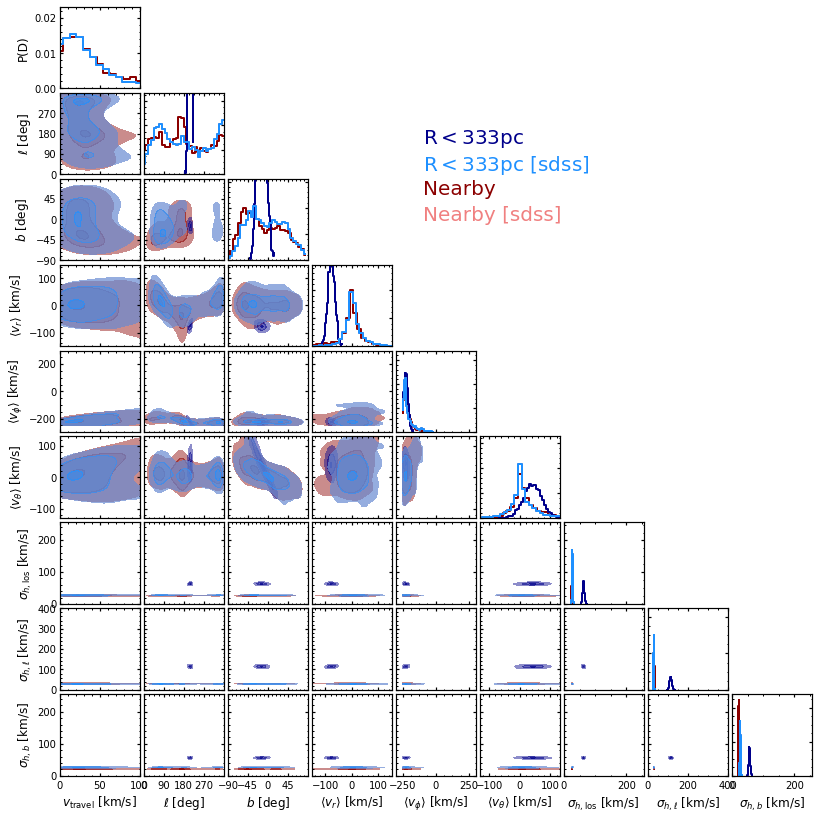

In [55]:


mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True

usecats = ['vtravel','phi','theta','vra','vphi','vth','sigmar','sigmap','sigmat']

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

decoded = ['$v_{\\rm travel}$ [km/s]','$\ell$ [deg]','$b$ [deg]',\
           '$\\langle v_r\\rangle$ [km/s]','$\\langle v_{\\phi}\\rangle $ [km/s]','$\\langle v_{\\theta}\\rangle$ [km/s]',\
          '$\\sigma_{h,{\\rm los}}$ [km/s]','$\\sigma_{h,\ell}$ [km/s]','$\\sigma_{h,b}$ [km/s]']


dictnames = [N1,N2,N1s,N2s]
colorlist = ['darkred','darkblue','lightcoral','dodgerblue']





# override angular bounddict coordinates
bounddict['vtravel'] = [0.,100.]
bounddict['phi'] = [0.,360.]
bounddict['theta'] = [-90.,90]
bounddict['vra'] = [-150.,150.]
bounddict['vphi'] = [-300.,300.]
bounddict['vth'] = [-130.,130.]

bounddict['sigmat'] = [0.,255.]
bounddict['sigmap'] = [0.,400.]
bounddict['sigmar'] = [0.,255.]





fig = plt.figure(figsize=(12,12))

xmin = 0.08
ymin = 0.07
ncats = len(usecats)
ncats1 = len(usecats)-1
dx = 0.83/ncats
dy = 0.85/ncats
buf = 0.005

binset = [75.,92.,99.5]

for u1i,u1 in enumerate(usecats):
    for u2i,u2 in enumerate(usecats):
        if u2i>u1i: continue
        if u2==u1: continue
        print(ncats-u1i,u2i,u1,u2)
        # u2i is the col
        # u1i is the row
        ax = fig.add_axes([xmin+u2i*(dx+buf),ymin+(ncats-u1i-1)*(dy+buf),dx,dy])
        
        inbounds = [bounddict[u2][0],bounddict[u2][1],\
                 bounddict[u1][0],bounddict[u1][1]]
        #xx,yy,dens,dadb = make_banana(SAT[u2],SAT[u1])
        for idict,dictname in enumerate(dictnames):
            if dictname==ALL:
                plot_banana(ax,dictname,u2,u1,colorlist[idict],border=True,binset=binset)

            elif dictname==SAT:
                if ((u1=='theta')|(u2=='theta')):
                    plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,bounds=inbounds,binset=[85.,94.,99.5],alphashade=0.15,alphazero=0.3)
                else:
                    plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,binset=[85.,94.,99.5],alphashade=0.15,alphazero=0.3)
                
            else:
                plot_banana(ax,dictname,u2,u1,colorlist[idict],border=False,binset=binset,alphashade=0.15,alphazero=0.3)
        
        if (ncats-u1i-1)==0:
            ax.set_xlabel(decoded[u2i],size=12)
        else:
            ax.set_xticklabels(())
            
        if (u2i)==0:
            ax.set_ylabel(decoded[u1i],size=12)
        else:
            ax.set_yticklabels(())
            
        ax.axis(inbounds)
        
        if (u1=='phi'):
            ax.set_yticks([0.,90.,180.,270.])
            
        if (u2=='phi'):
            ax.set_xticks([0.,90.,180.,270.])
        
        if (u1=='theta'):
            ax.set_yticks([-90.,-45.,0.,45.])            
    
        if (u2=='theta'):
            ax.set_xticks([-90.,-45.,0.,45.])
        
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis="y",which='both',direction="in")
        ax.tick_params(axis="x",which='both',direction="in",pad=5)
        

for u1i,u1 in enumerate(usecats):
    ax = fig.add_axes([xmin+u1i*(dx+buf),ymin+(ncats-u1i-1)*(dy+buf),dx,dy])

    for idict,dictname in enumerate(dictnames):
        A,B = norm_histogram(dictname[u1],bins=30)

        ax.plot(A,B,color=colorlist[idict],linestyle='steps-mid')
        
    ax.axis([bounddict[u1][0],bounddict[u1][1],0.,0.12])
    
    ax.axis([bounddict[u1][0],bounddict[u1][1],0.,1.5*np.nanmax(B)])

    if (u1=='phi'):
        ax.set_xticks([0.,90.,180.,270.])
    if (u1=='theta'):
        ax.set_xticks([-90.,-45.,0.,45.])
        
    if (ncats-u1i-1)>0:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel(decoded[u1i],size=12)
    
    if u1i!=0:
        ax.set_yticklabels(())
    else:
        ax.set_ylabel('P(D)',size=12)
        
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)
    
  
tsize = 20

plt.text( 0.5, 0.82, 'R$<333$pc', color='darkblue',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.79, 'R$<333$pc [sdss]', color='dodgerblue',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.76, 'Nearby', color='darkred',size=tsize,ha='left', va='top', transform=fig.transFigure ) 
plt.text( 0.5, 0.73, 'Nearby [sdss]', color='lightcoral',size=tsize,ha='left', va='top', transform=fig.transFigure ) 



plt.savefig('figures/comp_nearby.png',dpi=300)












In [56]:

def report_posteriors(posteriors):
    
    usecats = ['vtravel','phi','theta','vra','vphi','vth','sigmar','sigmap','sigmat']

    decoded = ['$v_{\\rm travel}$ [km/s]','$\ell$ [deg]','$b$ [deg]',\
           '$\\langle v_r\\rangle$ [km/s]','$\\langle v_{\\phi}\\rangle $ [km/s]','$\\langle v_{\\theta}\\rangle$ [km/s]',\
          '$\\sigma_{h,{\\rm los}}$ [km/s]','$\\sigma_{h,\ell}$ [km/s]','$\\sigma_{h,b}$ [km/s]']


    
    for ikey,key in enumerate(usecats):
        print('{0} & '.format(decoded[ikey]),end='')
        for posterior in posteriors:
        
            lodiff = np.percentile(posterior[key],50.)-np.percentile(posterior[key],50.-33.3)
            midriff = np.percentile(posterior[key],50.)
            hidiff = np.percentile(posterior[key],50.+33.3)-np.percentile(posterior[key],50.)
            print('${0:2.0f}^{{+{1:2.0f}}}_{{-{2:2.0f}}}$ '.format(midriff,hidiff,lodiff),end='')
            if posterior != SAT:
                print('&',end='')
        print('\\\\')


dictnames = [N1,N2,N1s,N2s]
colorlist = ['darkred','darkblue','lightcoral','dodgerblue']


report_posteriors([N1,N2,N1s,N2s])

$v_{\rm travel}$ [km/s] & $36^{+63}_{-22}$ &$177^{+13}_{-12}$ &$34^{+68}_{-22}$ &$34^{+68}_{-22}$ &\\
$\ell$ [deg] & $169^{+133}_{-109}$ &$209^{+ 5}_{- 6}$ &$172^{+147}_{-106}$ &$172^{+147}_{-106}$ &\\
$b$ [deg] & $-17^{+54}_{-37}$ &$-14^{+ 9}_{- 8}$ &$-6^{+46}_{-39}$ &$-6^{+46}_{-39}$ &\\
$\langle v_r\rangle$ [km/s] & $-1^{+24}_{-31}$ &$-77^{+12}_{-12}$ &$ 3^{+29}_{-22}$ &$ 3^{+29}_{-22}$ &\\
$\langle v_{\phi}\rangle $ [km/s] & $-221^{+31}_{-15}$ &$-225^{+16}_{-14}$ &$-221^{+52}_{-14}$ &$-221^{+52}_{-14}$ &\\
$\langle v_{\theta}\rangle$ [km/s] & $ 8^{+46}_{-23}$ &$41^{+28}_{-27}$ &$ 4^{+38}_{-23}$ &$ 4^{+38}_{-23}$ &\\
$\sigma_{h,{\rm los}}$ [km/s] & $26^{+ 1}_{- 1}$ &$63^{+ 3}_{- 3}$ &$27^{+ 1}_{- 1}$ &$27^{+ 1}_{- 1}$ &\\
$\sigma_{h,\ell}$ [km/s] & $31^{+ 1}_{- 1}$ &$114^{+ 5}_{- 5}$ &$29^{+ 1}_{- 1}$ &$29^{+ 1}_{- 1}$ &\\
$\sigma_{h,b}$ [km/s] & $21^{+ 1}_{- 1}$ &$56^{+ 2}_{- 2}$ &$26^{+ 1}_{- 1}$ &$26^{+ 1}_{- 1}$ &\\


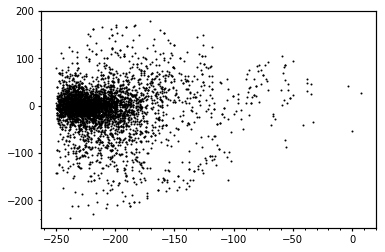

In [67]:
plt.scatter(N1['vphi'],N1['vra'],color='black',s=1.)